In [89]:
!python --version

Python 3.8.6


In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import pathlib
import random
import datetime
import functools
import pickle

In [91]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [92]:
root_dir = pathlib.WindowsPath(".")
root_temp_dir = pathlib.Path(root_dir)
code_dir = pathlib.Path(root_dir)
temp_dir = pathlib.Path(root_temp_dir, "_Temporary")
temp_dir.mkdir(exist_ok = True, parents = True)

In [93]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bahug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [95]:
import re

In [96]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.3.0


In [97]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [98]:
tf.test.is_gpu_available()

True

In [99]:
df = pd.read_csv('../trainingandtestdata/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [100]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [101]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [102]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]

In [103]:
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [104]:
val_count = df.sentiment.value_counts()

Text(0.5, 1.0, 'Sentiment Data Distribution')

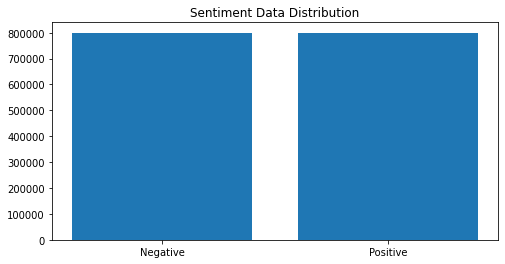

In [105]:
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [106]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1553733,Positive,Today was not too shabby of a day.
371199,Negative,SAT tomorrow sucks tomorrow is going to be a ...
966599,Positive,@hillary64 hey your gonna get it too so dnt ev...
974894,Positive,Watching sonny with a chance hannah montana an...
723277,Negative,"@mwikkid that was supposed to be private, jerk..."
622623,Negative,i had salt &amp; pepper tofu for lunch. bummed...
1397379,Positive,@ji_ric No real plans just a regular weekend
296629,Negative,Wow. The Sims 3 is getting a lot of 90% rating...
1107503,Positive,i think today is going to be a great day. the...
480521,Negative,today i wore hilary's rolling stone t-shirt th...


In [107]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

#text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+(?<![\w.-])@[A-Za-z][\w-]+"

In [108]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [109]:
df.text = df.text.apply(lambda x: preprocess(x))

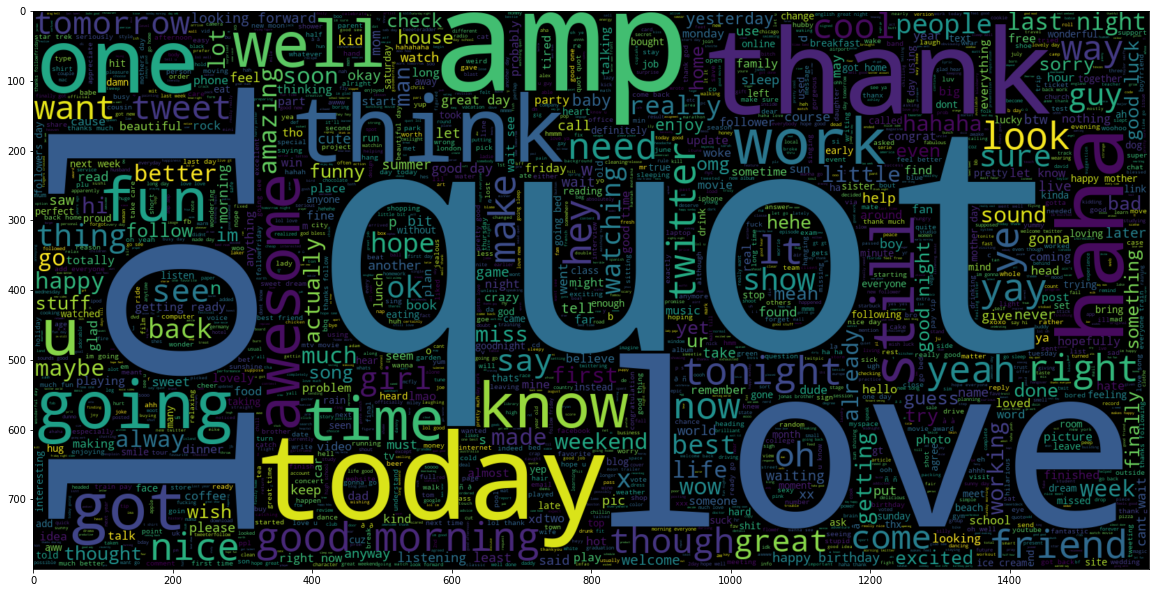

In [110]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [111]:
TRAIN_SIZE = 0.8

In [112]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [113]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [114]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call! impossible
476661,Negative,good pace going (3k 13 min) missed 5k turn end...
1181490,Positive,u gonna shows ny soon?? i've luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,"yeah, where? need 2 see ur mom calls back firs..."
1235876,Positive,sounds like cup tea. sign up?
717314,Negative,"i'm tired want sleep, wtf"
969880,Positive,- amazing!! wish too!
748698,Negative,thank god wkrn abc affiliate nashville back ag...


In [115]:
test_data.head(10)

,sentiment,text
709290,Negative,feelin lately i've reason
654075,Negative,"ju, clare, elly zoe leave marbella"
728623,Negative,wish couldve seen miley nick sing 2night.
697650,Negative,"work today. 1 hour down, 6 go."
1244425,Positive,started catch house viewing. kind odd watched ...
471810,Negative,"yeah i've already applied couple, one really w..."
928654,Positive,watching spanish television mom
81604,Negative,2 days go still know do... even spend 2k? mom ...
395779,Negative,heart breaking news! mustang travelled accross...
874650,Positive,time disconnect fantastic dinner waiting great...


In [116]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 274936


In [117]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [118]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [119]:
labels = train_data.sentiment.unique().tolist()

In [120]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [121]:
GLOVE_EMB = '../wordEmbedding/glove.twitter.27B/glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = './output/best_model.hdf5'

In [122]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [123]:
print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [124]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [125]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [126]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [127]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [128]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
temp_model_dir = pathlib.Path(temp_dir)
temp_model_dir.mkdir(exist_ok = True, parents = True)
er_path = pathlib.Path(temp_model_dir, "savedModel.pkl")

In [129]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=11,validation_data=(x_test, y_test),use_multiprocessing=False, callbacks=[ReduceLROnPlateau])


Epoch 1/11
1250/1250 [==============================] - 143s 115ms/step - loss: 0.4948 - accuracy: 0.7565 - val_loss: 0.4598 - val_accuracy: 0.7800
Epoch 2/11
1250/1250 [==============================] - 167s 133ms/step - loss: 0.4682 - accuracy: 0.7751 - val_loss: 0.4502 - val_accuracy: 0.7862
Epoch 3/11
1250/1250 [==============================] - 170s 136ms/step - loss: 0.4597 - accuracy: 0.7801 - val_loss: 0.4483 - val_accuracy: 0.7879
Epoch 4/11
1250/1250 [==============================] - 189s 151ms/step - loss: 0.4540 - accuracy: 0.7839 - val_loss: 0.4457 - val_accuracy: 0.7890
Epoch 5/11
1250/1250 [==============================] - 195s 156ms/step - loss: 0.4500 - accuracy: 0.7861 - val_loss: 0.4412 - val_accuracy: 0.7921
Epoch 6/11
1250/1250 [==============================] - 192s 154ms/step - loss: 0.4469 - accuracy: 0.7883 - val_loss: 0.4407 - val_accuracy: 0.7930
Epoch 7/11
1250/1250 [==============================] - 194s 155ms/step - loss: 0.4446 - accuracy: 0.7893 - val_

In [130]:
model.save("my_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


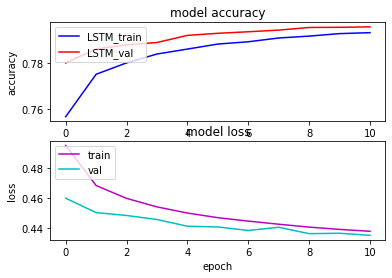

In [131]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [132]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

In [133]:
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 7s 208ms/step


In [134]:
mytest = ["This is great", "This is bad"]
mytest_padding = pad_sequences(tokenizer.texts_to_sequences(mytest),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [136]:
myTest_scores = model.predict(mytest_padding, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 994us/step


In [137]:
myTest_pred_1d = [decode_sentiment(score) for score in myTest_scores]

In [138]:
myTest_pred_1d

['Positive', 'Negative']

In [139]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

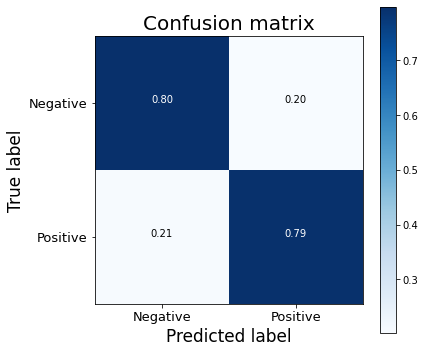

In [140]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [141]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80    160542
    Positive       0.80      0.79      0.79    159458

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [ ]:
## Twitter feed

In [17]:
import keras

In [18]:
model = keras.models.load_model("my_model")

In [13]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\bahug\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [14]:
import tweepy

In [29]:
consumer_key = "2kSfj8TQAPWbKH7EOCM2sh1lw"
consumer_secret = "4DgWq1YpYGj4fBssiF6CVdY8qKoH0C0CJKUBOagek1oM7P6UoI"
access_token = "735672620700442624-lYgFDBzuZo6LpilkVRbrFkRfdMeTmYn"
access_token_secret = "O26Q6EH62aW5LTuhR4dARjWzKLwY49Lmc9S4GNXRcCGBS"

In [30]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth) 

In [17]:
name = "uber"
# Number of tweets to pull
tweetCount = 20
results = api.user_timeline(id=name, count=tweetCount, include_rts=False)
for tweet in results:
   print (tweet.text)

@SresthaDasChou1 Hey Srestha, while our safety guidelines don't have it as a compulsion, we strongly recommend to,… https://t.co/3aLyfWmw56
@BISWAJITPAUL21 Hey there, it looks like the account registered with 9830087007 might have accidentally created mul… https://t.co/zmMpwVbOyl
@Braeboicarti We are sorry to hear about this experience and would like to follow up with you for more information.… https://t.co/lchNbPoFgR
Meta Uber Pool https://t.co/JZvBx3KRTi
@StevieNorrisxo Hi Stevie, we are happy to help. Please follow our support page: https://t.co/V1lNEfvI9k so our Ube… https://t.co/xLrBwi6elq
@sheni_coker Just like drivers, saying thank you takes you places. ❤️
@momcrotch Thanks for riding safely. ❤️
@lexyluvsnia We are sorry to hear about this experience and would like to follow up with you for more information.… https://t.co/47oPNbSq3k
@Swapnil6098 Hey Swapnil, this is certainly not the experience we expect you to have on the platform. We've made a… https://t.co/IqdkfeMBGs
@JohnMil

In [33]:
inputArray = []
search_words = "#uber"
date_since = "2020-01-01"
for tweet in tweepy.Cursor(api.search,q=search_words+" -filter:retweets",lang="en",since=date_since, result_type='recent', timeout=999999, include_rts=False).items(10):
    inputArray.append(tweet.text)
input_df = pd.DataFrame(inputArray,columns=['text'])

In [34]:
input_df

,text
0,@TeachGrant @OmariAkilNewton @JennMacA @Uber D...
1,Food delivery deaths: NSW transport minister c...
2,Haseeb el ta3leem w asht8al f uber eats @UberE...
3,How Loss Aversion Bias helped Uber beat the ta...
4,@UberEats @ubereats_uk don’t ever order from h...
5,Next time when you take an #Uber or hitch a ri...
6,#Uber seek Localization Program Managers in #B...
7,@Mochievous #Lyft &amp; #Uber use @checkr for ...
8,$UBER Some more hints about this setting.\n\nT...
9,Are you a Blockbuster or a #Netflix? Business ...


In [19]:
def preprocessInput(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [38]:
input_df.text = input_df.text.apply(lambda x: preprocessInput(x))

In [39]:
input_df

,text
0,omariakilnewton jennmaca uber data protection ...
1,food delivery deaths nsw transport minister cr...
2,haseeb el ta3leem w asht8al f uber eats uberea...
3,loss aversion bias helped uber beat taxi indus...
4,ubereats uk ever order wrong order turned clai...
5,next time take uber hitch ride office remember...
6,uber seek localization program managers buenos...
7,lyft amp uber use checkr background checks nei...
8,uber hints setting verticality actually someth...
9,blockbuster netflix business models fire tech ...


In [40]:
inputList = np.array(input_df).flatten()

In [41]:
inputList

array(['omariakilnewton jennmaca uber data protection serious problem uber uncle similar',
       'food delivery deaths nsw transport minister criticised victim blaming minicab uber addisonlee taxi gr',
       'haseeb el ta3leem w asht8al f uber eats ubereats sponsor please uber',
       'loss aversion bias helped uber beat taxi industry loss aversion bias',
       'ubereats uk ever order wrong order turned claimed refund still received af',
       'next time take uber hitch ride office remember open car window closest',
       'uber seek localization program managers buenosaires argentina opaulo brazil mexicocity mexico',
       'lyft amp uber use checkr background checks neither company responsible 3rd party',
       'uber hints setting verticality actually something inverted shs scenario must',
       'blockbuster netflix business models fire tech driven service based models massively'],
      dtype=object)

In [20]:
tokenizer
with open('tokenizer.pickle', 'rb') as handle:
     tokenizer = pickle.load(handle)

In [84]:
input_df_padding = pad_sequences(tokenizer.texts_to_sequences(inputList),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [86]:
input_df_scores = model.predict(input_df_padding, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 2ms/step


In [89]:
input_df_pred_1d = [decode_sentiment(score) for score in input_df_scores]

In [90]:
input_df_pred_1d

['Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative']

In [ ]:
# Reddit 

In [61]:
import requests
import simplejson as json
def getPushshiftData(query, after, sub):
    url = 'https://api.pushshift.io/reddit/search/comment/?title='+str(query)+'&size=1&after='+str(after)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [63]:
query=""
after="1d"
sub = "uber"
redditData = getPushshiftData(query, after, sub)

https://api.pushshift.io/reddit/search/comment/?title=&size=1&after=1d&subreddit=uber


In [68]:
data

[{'all_awardings': [],
  'associated_award': None,
  'author': 'OnlyPharah',
  'author_flair_background_color': None,
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_template_id': None,
  'author_flair_text': None,
  'author_flair_text_color': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_550eyzgb',
  'author_patreon_flair': False,
  'author_premium': False,
  'awarders': [],
  'body': 'Some would call that a finders fee and an expensive lesson to you - keep track of your shit.',
  'collapsed_because_crowd_control': None,
  'comment_type': None,
  'created_utc': 1607270196,
  'gildings': {},
  'id': 'geubq32',
  'is_submitter': False,
  'link_id': 't3_k7tut8',
  'locked': False,
  'no_follow': True,
  'parent_id': 't3_k7tut8',
  'permalink': '/r/uber/comments/k7tut8/theft_or_legitimate_compensation/geubq32/',
  'retrieved_on': 1607270427,
  'score': 1,
  'send_replies': True,
  'stickied': False,
  'subreddit': 'uber',
  'subreddit_id': 

In [69]:
for x in data:
    print (x["body"])

Some would call that a finders fee and an expensive lesson to you - keep track of your shit.


In [80]:
twt = "https://twitter.com/uber?lang=en"
red="https://www.reddit.com/r/uber/"

In [85]:
#twitter regex
twitter = re.search("^(?:https?:\/\/)?(?:www.)?(?:twitter.com)?[\/@]?([^\/?\s]+)",twt).group(1)

In [86]:
twitter

'uber'

In [87]:
#Reddit regex
reddit = re.search("^(?:https?:\/\/)?(?:www.)?(?:reddit.com\/r)?[\/]?([^\/?\s]+)",red).group(1)

In [88]:
reddit

'uber'